In [ ]:
from google.colab import drive # Подключаем google disk
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Stajirovka/crop.zip -d /content/

In [ ]:
# Проверка о том, что работает на GPU
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU')) 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras.applications import EfficientNetB0, MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, UpSampling2D

2023-03-17 21:00:01.942087: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
import matplotlib
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Using matplotlib backend: <object object at 0x7fdaef6febd0>


# Классификатор конвалюшн сетки

In [ ]:
# Загружам датафрем
df = pd.read_csv('./Загрузки/df_with_human_classification.csv')
df.head(10)

,file_name,center_x,center_y,a,b,c,d,x,y,w,h,ssim,pnsr,mse,histDitance,n_hamming_distance,hash,hashPercent,previous_cropUrl,destination
0,./crop/0-grWg9.jpg,1153.0,714.0,1356.172924,1356.172924,1356.172924,1356.172924,1026,535,1280,893,0.132794,12.339354,87.931129,71843,0.296875,18300826926748532736,70.3125,./crop/0-2zUwL.jpg,2.0
1,./crop/1-EktKu.jpg,1112.0,741.5,1336.550130,1336.550130,1336.550130,1336.550130,945,502,1279,981,0.244592,12.044071,71.724329,58692,0.203125,18445830245069094912,79.6875,./crop/0-grWg9.jpg,2.0
2,./crop/1-C7A1m.jpg,1179.0,676.5,1359.298808,1359.298808,1359.298808,1359.298808,1079,507,1279,846,0.102524,10.999856,89.224545,38797,0.328125,18012697565006463488,67.1875,./crop/1-rHefO.jpg,2.0
3,./crop/1-wiyGz.jpg,1142.5,835.0,1415.108211,1415.108211,1415.108211,1415.108211,1005,670,1280,1000,0.059230,11.199795,90.186086,125520,0.343750,10230474110371139585,65.6250,./crop/1-3ryNx.jpg,2.0
4,./crop/2-WE2S6.jpg,1106.0,744.5,1333.235257,1333.235257,1333.235257,1333.235257,935,502,1277,987,0.220679,11.073861,69.956566,7505,0.265625,18445865429441183744,73.4375,./crop/1-wiyGz.jpg,2.0
5,./crop/3-uLQq7.jpg,1100.5,735.5,1323.654222,1323.654222,1323.654222,1323.654222,921,499,1280,972,0.318487,13.652413,67.602749,2203,0.062500,18302031721710747648,93.7500,./crop/2-WE2S6.jpg,2.0
6,./crop/3-lCUZy.jpg,1163.0,626.0,1320.774394,1320.774394,1320.774394,1320.774394,1046,503,1280,749,0.160014,10.485408,87.571739,111389,0.250000,17994609086888411521,75.0000,./crop/3-uLQq7.jpg,2.0
7,./crop/4-XPKNB.jpg,1110.5,752.5,1341.441948,1341.441948,1341.441948,1341.441948,974,513,1247,992,0.111907,10.971557,87.094544,95948,0.250000,18158444294661210112,75.0000,./crop/3-lCUZy.jpg,2.0
8,./crop/5-KfKJH.jpg,1108.0,765.0,1346.435665,1346.435665,1346.435665,1346.435665,974,543,1242,987,0.405315,14.381329,57.451648,14139,0.093750,18442172169069789184,90.6250,./crop/4-XPKNB.jpg,2.0
9,./crop/6-c8YO7.jpg,1121.0,756.5,1352.380586,1352.380586,1352.380586,1352.380586,967,518,1275,995,0.325157,13.875262,66.433091,9485,0.093750,18297492937434464256,90.6250,./crop/5-KfKJH.jpg,2.0


In [ ]:
df.shape

(10865, 20)

In [ ]:
# Удаляем пропуски в столбце "destination"
df_ = df.dropna(axis=0, how='any')
df_

,file_name,center_x,center_y,a,b,c,d,x,y,w,h,ssim,pnsr,mse,histDitance,n_hamming_distance,hash,hashPercent,previous_cropUrl,destination
0,./crop/0-grWg9.jpg,1153.0,714.0,1356.172924,1356.172924,1356.172924,1356.172924,1026,535,1280,893,0.132794,12.339354,87.931129,71843,0.296875,18300826926748532736,70.3125,./crop/0-2zUwL.jpg,2.0
1,./crop/1-EktKu.jpg,1112.0,741.5,1336.550130,1336.550130,1336.550130,1336.550130,945,502,1279,981,0.244592,12.044071,71.724329,58692,0.203125,18445830245069094912,79.6875,./crop/0-grWg9.jpg,2.0
2,./crop/1-C7A1m.jpg,1179.0,676.5,1359.298808,1359.298808,1359.298808,1359.298808,1079,507,1279,846,0.102524,10.999856,89.224545,38797,0.328125,18012697565006463488,67.1875,./crop/1-rHefO.jpg,2.0
3,./crop/1-wiyGz.jpg,1142.5,835.0,1415.108211,1415.108211,1415.108211,1415.108211,1005,670,1280,1000,0.059230,11.199795,90.186086,125520,0.343750,10230474110371139585,65.6250,./crop/1-3ryNx.jpg,2.0
4,./crop/2-WE2S6.jpg,1106.0,744.5,1333.235257,1333.235257,1333.235257,1333.235257,935,502,1277,987,0.220679,11.073861,69.956566,7505,0.265625,18445865429441183744,73.4375,./crop/1-wiyGz.jpg,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,./crop/1082-ZtnK5.jpg,373.5,556.5,670.219740,670.219740,670.219740,670.219740,271,399,476,714,0.203965,11.840860,99.584528,76410,0.484375,16107075497669771456,51.5625,./crop/1081-yTqXw.jpg,0.0
1396,./crop/1082-S80st.jpg,339.0,807.5,875.772373,875.772373,875.772373,875.772373,155,615,523,1000,0.159583,11.851457,99.614613,76772,0.468750,17415618516788207728,53.1250,./crop/1082-ZtnK5.jpg,0.0
1397,./crop/1083-ME00Q.jpg,373.5,556.0,669.804636,669.804636,669.804636,669.804636,272,401,475,711,0.202201,11.891180,99.799696,76749,0.437500,16107075497678160096,56.2500,./crop/1082-S80st.jpg,0.0
1398,./crop/1083-kJY6q.jpg,338.5,807.5,875.578951,875.578951,875.578951,875.578951,155,616,522,999,0.158889,11.883368,100.067986,71225,0.437500,17406611454905344112,56.2500,./crop/1083-ME00Q.jpg,0.0


In [ ]:
# Удаляем все столбцы кроме "file_name", "destination"
df_.drop(df_.columns[1:19], axis=1, inplace=True)
df_

/tmp/ipykernel_9567/2986240622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.drop(df_.columns[1:19], axis=1, inplace=True)


,file_name,destination
0,./crop/0-grWg9.jpg,2.0
1,./crop/1-EktKu.jpg,2.0
2,./crop/1-C7A1m.jpg,2.0
3,./crop/1-wiyGz.jpg,2.0
4,./crop/2-WE2S6.jpg,2.0
...,...,...
1395,./crop/1082-ZtnK5.jpg,0.0
1396,./crop/1082-S80st.jpg,0.0
1397,./crop/1083-ME00Q.jpg,0.0
1398,./crop/1083-kJY6q.jpg,0.0


In [ ]:
df_['image'] = None # Добовляем столбец "image"
df_['destination'] = df_['destination'].astype(int)# переводим в int
df_

/tmp/ipykernel_9567/3780694703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['image'] = None
/tmp/ipykernel_9567/3780694703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['destination'] = df_['destination'].astype(int)


,file_name,destination,image
0,./crop/0-grWg9.jpg,2,None
1,./crop/1-EktKu.jpg,2,None
2,./crop/1-C7A1m.jpg,2,None
3,./crop/1-wiyGz.jpg,2,None
4,./crop/2-WE2S6.jpg,2,None
...,...,...,...
1395,./crop/1082-ZtnK5.jpg,0,None
1396,./crop/1082-S80st.jpg,0,None
1397,./crop/1083-ME00Q.jpg,0,None
1398,./crop/1083-kJY6q.jpg,0,None


In [ ]:
# В столбец image записываем масивы из фото
def load(imPath):
    img = Image.open(imPath)
    img = img.resize((224, 224))
    img_array = np.array(img)
    return img_array
df_['image'] = df_['file_name'].apply(lambda x: load(x))

/tmp/ipykernel_9567/2376898782.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['image'] = df_['file_name'].apply(lambda x: load(x))


In [ ]:
df_.head()

,file_name,destination,image
0,./crop/0-grWg9.jpg,2,"[[[167, 179, 179], [185, 194, 195], [207, 211,..."
1,./crop/1-EktKu.jpg,2,"[[[30, 32, 31], [134, 136, 135], [188, 190, 18..."
2,./crop/1-C7A1m.jpg,2,"[[[157, 169, 169], [160, 171, 170], [166, 173,..."
3,./crop/1-wiyGz.jpg,2,"[[[141, 141, 133], [142, 142, 134], [155, 155,..."
4,./crop/2-WE2S6.jpg,2,"[[[166, 174, 176], [164, 172, 175], [180, 187,..."


In [ ]:
print(data.head())

            file_name  destination  \
0  ./crop/0-grWg9.jpg            2   
1  ./crop/1-EktKu.jpg            2   
2  ./crop/1-C7A1m.jpg            2   
3  ./crop/1-wiyGz.jpg            2   
4  ./crop/2-WE2S6.jpg            2   

                                               image  
0  [[[167, 179, 179], [185, 194, 195], [207, 211,...  
1  [[[30, 32, 31], [134, 136, 135], [188, 190, 18...  
2  [[[157, 169, 169], [160, 171, 170], [166, 173,...  
3  [[[141, 141, 133], [142, 142, 134], [155, 155,...  
4  [[[166, 174, 176], [164, 172, 175], [180, 187,...  


In [ ]:
from tensorflow.keras.utils import to_categorical

x_data = np.array(data['image'].tolist())
y_data = data['destination']

print(len(x_data))

y_data = to_categorical(y_data, 3)

print(x_data.shape)
print(y_data.shape)

1400
(1400, 224, 224, 3)
(1400, 3)


In [ ]:
# разделяем данные на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

In [ ]:
x_train[:1]

array([[[[  2,   0,  33],
         [  4,   0,  36],
         [  5,   1,  39],
         ...,
         [196, 255, 255],
         [165, 238, 247],
         [158, 238, 248]],

        [[ 57,  48,  90],
         [ 67,  60,  99],
         [ 84,  78, 119],
         ...,
         [166, 220, 240],
         [172, 237, 252],
         [167, 240, 253]],

        [[225, 213, 241],
         [226, 215, 241],
         [201, 189, 227],
         ...,
         [158, 201, 230],
         [128, 180, 216],
         [165, 224, 253]],

        ...,

        [[168, 140, 122],
         [166, 137, 120],
         [217, 190, 171],
         ...,
         [ 35,  24,  22],
         [ 34,  23,  21],
         [ 35,  24,  22]],

        [[235, 207, 193],
         [222, 195, 179],
         [199, 172, 157],
         ...,
         [ 33,  22,  20],
         [ 34,  23,  21],
         [ 33,  22,  20]],

        [[209, 182, 170],
         [201, 175, 162],
         [137, 111,  99],
         ...,
         [ 31,  20,  18],
        

In [ ]:
y_train[:1]

array([[1., 0., 0.]], dtype=float32)

In [ ]:
x_test[:1]

array([[[[ 49,  31,  27],
         [ 55,  37,  32],
         [ 57,  41,  33],
         ...,
         [153, 152, 157],
         [154, 153, 158],
         [156, 155, 160]],

        [[ 58,  39,  35],
         [ 56,  38,  33],
         [ 55,  39,  31],
         ...,
         [144, 143, 148],
         [146, 145, 150],
         [147, 146, 151]],

        [[ 57,  38,  34],
         [ 56,  37,  32],
         [ 56,  38,  32],
         ...,
         [135, 134, 139],
         [137, 136, 141],
         [137, 136, 141]],

        ...,

        [[ 43,  40,  33],
         [ 70,  67,  61],
         [ 90,  86,  83],
         ...,
         [  3,   3,   1],
         [  1,   0,   0],
         [ 16,  15,  13]],

        [[ 38,  36,  24],
         [ 51,  48,  40],
         [ 77,  73,  68],
         ...,
         [  2,   2,   2],
         [  1,   1,   0],
         [  1,   1,   1]],

        [[ 43,  41,  28],
         [ 44,  42,  32],
         [ 59,  55,  50],
         ...,
         [  1,   3,   2],
        

In [ ]:
y_test[:1]

array([[0., 0., 1.]], dtype=float32)

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False,  input_shape=(224, 224, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)
print(model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
checkpoint = ModelCheckpoint(filepath='best_uniform_model.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
log = model.fit(x_train, y_train,
                  validation_split=0.2,
                  epochs = 10,
                  batch_size = 32,
                  verbose=1,
                  callbacks=[checkpoint])

Epoch 1/10
25/25 [==============================] - 5s 177ms/step - loss: 1.0622 - accuracy: 0.5836 - val_loss: 2.3650 - val_accuracy: 0.4337

Epoch 00001: val_loss improved from inf to 2.36502, saving model to best_uniform_model.h5
Epoch 2/10
25/25 [==============================] - 4s 170ms/step - loss: 0.1855 - accuracy: 0.9497 - val_loss: 1.4992 - val_accuracy: 0.5357

Epoch 00002: val_loss improved from 2.36502 to 1.49917, saving model to best_uniform_model.h5
Epoch 3/10
25/25 [==============================] - 4s 169ms/step - loss: 0.0779 - accuracy: 0.9768 - val_loss: 0.9779 - val_accuracy: 0.6276

Epoch 00003: val_loss improved from 1.49917 to 0.97792, saving model to best_uniform_model.h5
Epoch 4/10
25/25 [==============================] - 4s 172ms/step - loss: 0.0301 - accuracy: 0.9972 - val_loss: 0.6349 - val_accuracy: 0.7500

Epoch 00004: val_loss improved from 0.97792 to 0.63490, saving model to best_uniform_model.h5
Epoch 5/10
25/25 [==============================] - 4s 1

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.callbacks import LearningRateScheduler

# Создание callback функции остановки обучения
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min', restore_best_weights=True)

# Создание callback функции уменьшения learning rate
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 20:
        lr *= 0.1
    elif epoch > 15:
        lr *= 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

checkpoint = ModelCheckpoint(filepath='best_uniform_model.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
log = model.fit(x_train, y_train,
          validation_split=0.2,
          epochs=10,
         callbacks=[early_stop, lr_scheduler, checkpoint])


Epoch 1/10
25/25 [==============================] - 4s 173ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.1942 - val_accuracy: 0.9439

Epoch 00001: val_loss improved from inf to 0.19420, saving model to best_uniform_model.h5
Epoch 2/10
25/25 [==============================] - 4s 171ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.1837 - val_accuracy: 0.9439

Epoch 00002: val_loss improved from 0.19420 to 0.18368, saving model to best_uniform_model.h5
Epoch 3/10
25/25 [==============================] - 4s 172ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.1852 - val_accuracy: 0.9490

Epoch 00003: val_loss did not improve from 0.18368
Epoch 4/10
25/25 [==============================] - 4s 171ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.1937 - val_accuracy: 0.9490

Epoch 00004: val_loss did not improve from 0.18368
Epoch 5/10
25/25 [==============================] - 4s 173ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1852 - val_accuracy: 0.9541


In [ ]:
# Рисование графиков
import matplotlib.pyplot as plt

def show_history(history):

    # Отрисовка графика точности на обучающей выборке
    plt.plot(history.history['accuracy'],
             label='Доля верных ответов на обучающем наборе')

    # Отрисовка графика точности на проверочной выборке
    plt.plot(history.history['val_accuracy'],
             label='Доля верных ответов на проверочном наборе')

    # Отрисовка подписей осей
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')

    # Отрисовка легенды
    plt.legend()

    # Вывод графика
    plt.show()

In [ ]:
def show_error(history):
    plt.plot(history.history['loss'],
             label='Ошибка на обучающем наборе')

    plt.plot(history.history['val_loss'],
             label='Ошибка на проверочном наборе')

    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')

    plt.legend()

    plt.show()

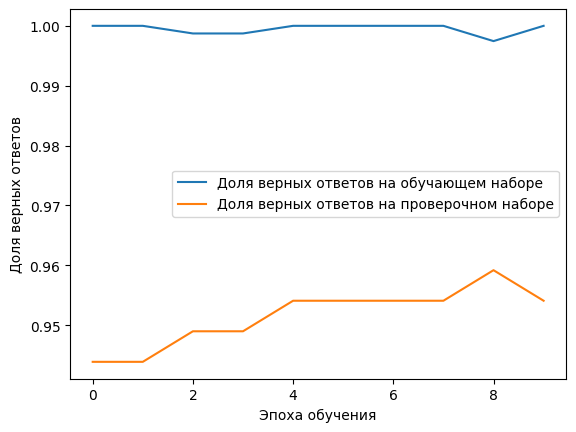

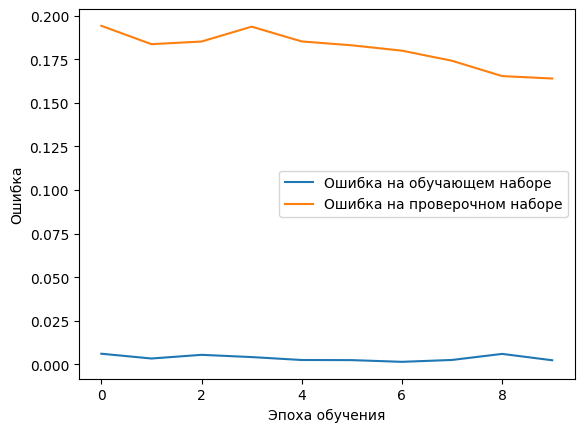

In [ ]:
show_history(log)
show_error(log)

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('best_uniform_model.h5')

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Процент верных ответов на тестовых данных:', round(scores[1],2) * 100, '%')

14/14 [==============================] - 1s 35ms/step - loss: 0.1420 - accuracy: 0.9643
Процент верных ответов на тестовых данных: 96.0 %


In [ ]:
pred = model.predict(x_test)

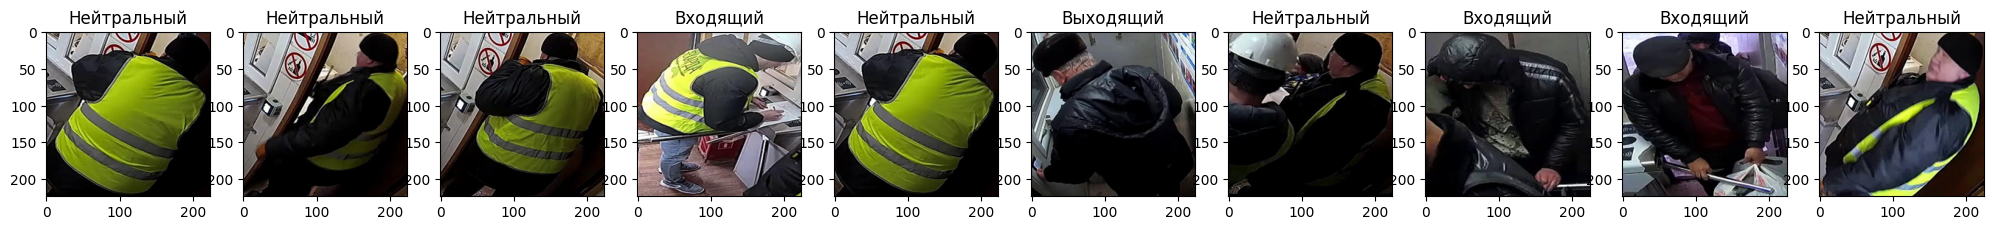

In [ ]:
rng = range(0, 399)
fig, axs = plt.subplots(1, 10, figsize=(25, 3)) #Создаем полотно из 10 графиков
for i in range(10): #Проходим по классам от 0 до 9
  index = random.choice(rng)
  axs[i].imshow(Image.fromarray(x_test[index]).convert('RGB'))
  if pred[index].argmax() == 0:
    axs[i].set_title('Входящий')
  elif pred[index].argmax() == 1:
    axs[i].set_title('Выходящий')
  elif pred[index].argmax() == 2:
    axs[i].set_title('Нейтральный')

plt.show() #Показываем изображения